In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
fig_kwargs = {"dpi": 200, "bbox_inches": "tight", "facecolor": "w"}

In [3]:
import pathlib

In [4]:
import numpy as np
import pandas as pd
import xarray as xr

In [5]:
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import xarray as xr
from dask.diagnostics import ProgressBar

In [6]:
from seasonal_forecasting import C3S, domains, geo, plot, utils, verification

In [7]:
def expand(domain, degrees):
    domain = [
        domain[0] - degrees,
        domain[1] + degrees,
        domain[2] - degrees,
        domain[3] + degrees,
    ]

    return domain

In [8]:
domain_name = "NZ"
use_verif = "oisst"
GCMs = [
    "ECMWF",
    "UKMO",
    "METEO_FRANCE",
    "DWD",
    "CMCC",
    "NCEP",
    "JMA",
    "ECCC_CanCM4i",
    "ECCC_GEM5_NEMO",
]
varname = "sst"
period = "monthly"  # 'seasonal' or 'monthly'
year_start = 1993
year_end = 2016
obs_to_1deg = False
climpred_verbose = False
q = 0.9

In [9]:
domain = domains.domains[domain_name]

In [10]:
domain

[161, 181, -50, -30]

In [11]:
area = geo.gpd_from_domain(*domain)

### reads the monthly OISST, see https://downloads.psl.noaa.gov/Datasets/noaa.oisst.v2.highres/ for data source and the notebook `update_OISST.ipynb` for the code to download the data 

In [12]:
oisst_path = pathlib.Path("/media/nicolasf/END19101/data/OISST/monthly/global")

In [13]:
lfiles = list(oisst_path.glob("*.nc"))

In [14]:
lfiles.sort()

In [15]:
dset_obs = xr.open_mfdataset(lfiles, parallel=True)

In [16]:
dset_obs = dset_obs.sel(lon=slice(*domain[:2]), lat=slice(*domain[2:]))

### detrend, using coefficient determined over 1993 - 2016

In [17]:
p = dset_obs[varname].sel(time=slice("1993", "2016")).polyfit(dim="time", deg=1)

In [18]:
fit = xr.polyval(dset_obs["time"], p.polyfit_coefficients)

In [19]:
dset_obs[f"{varname}_detrend"] = (dset_obs[varname] - fit) + dset_obs[varname].mean(
    dim="time"
)

In [20]:
dset_obs = dset_obs.sortby("time")

In [21]:
dset_clim = dset_obs.sel(time=slice("1993", "2016"))

In [22]:
dset_clim = dset_clim.groupby(dset_clim.time.dt.month).mean()

In [23]:
dset_obs_anoms = dset_obs.groupby(dset_obs.time.dt.month) - dset_clim

/home/nicolasf/mambaforge/envs/seasonal_forecasting/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 42 times more chunks
  return self.array[key]


In [24]:
with ProgressBar():
    dset_obs_anoms = dset_obs_anoms.compute()

[########################################] | 100% Completed | 2.09 sms


In [25]:
dset_obs = dset_obs.chunk({"time": -1, "lat": 10, "lon": 10})

### creates a mask from the observational dataset 

In [26]:
mask_obs = dset_obs.mean(dim="time")

In [27]:
mask_obs = mask_obs.where(np.isnan(mask_obs), 1)

In [28]:
mask_obs = mask_obs.rename({varname: "mask"})["mask"]

### plots the mask 

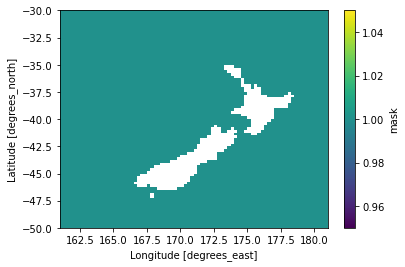

In [29]:
mask_obs.plot()

### calculates seasonal averages if 'seasonal' 

In [30]:
if period == "seasonal":
    dset_obs = dset_obs.rolling({"time": 3}, min_periods=3).mean("time")

    dset_obs = dset_obs.isel(time=slice(2, None))

    dset_obs_anoms = dset_obs_anoms.rolling({"time": 3}, min_periods=3).mean("time")

    dset_obs_anoms = dset_obs_anoms.isel(time=slice(2, None))

### calculates the quantile climatologies for the observations 

In [31]:
obs_edges = (
    dset_obs.sel(time=slice("1993", "2016"))
    .groupby("time.month")
    .quantile(q=q, dim="time")
    .rename({"quantile": "category_edge"})
)

In [32]:
with ProgressBar():
    obs_edges = obs_edges.compute()

[##                                      ] | 6% Completed | 638.81 ms

/home/nicolasf/mambaforge/envs/seasonal_forecasting/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


[########################################] | 100% Completed | 27.65 s


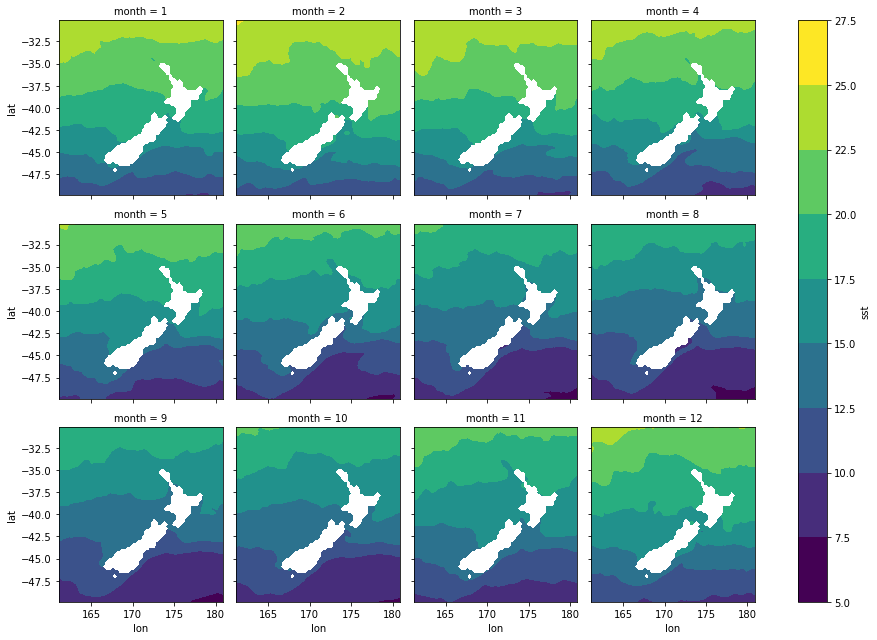

In [33]:
obs_edges[varname].plot.contourf(col="month", col_wrap=4, levels=10)

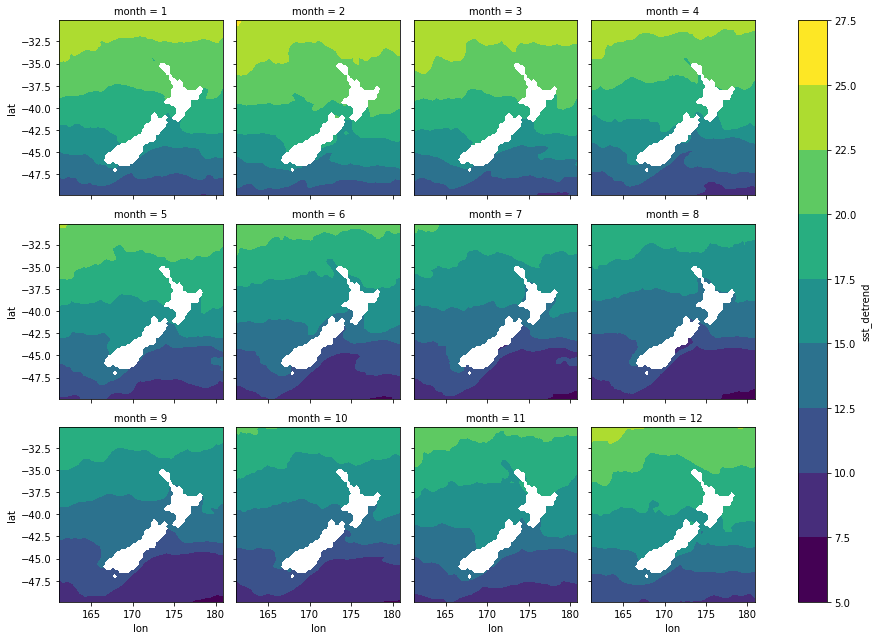

In [34]:
obs_edges[f"{varname}_detrend"].plot.contourf(col="month", col_wrap=4, levels=10)

In [35]:
obs_binary = []

for m in np.arange(12) + 1:
    
    obsm = dset_obs.sel(time=(dset_obs.time.dt.month == m))

    qm = obs_edges.sel(month=m)

    b = obsm >= qm

    obs_binary.append(b * mask_obs)

In [36]:
obs_binary = xr.concat(obs_binary, dim="time")

In [ ]:
obs_binary = obs_binary.sortby('lat')

In [37]:
obs_binary = obs_binary.squeeze()

In [38]:
obs_binary

<xarray.Dataset>
Dimensions:        (lat: 80, lon: 80, time: 499)
Coordinates:
  * lat            (lat) float32 -49.88 -49.62 -49.38 ... -30.62 -30.38 -30.12
  * lon            (lon) float32 161.1 161.4 161.6 161.9 ... 180.4 180.6 180.9
  * time           (time) datetime64[ns] 1982-01-01 1983-01-01 ... 2022-12-01
    category_edge  float64 0.9
    month          (time) int64 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12
Data variables:
    sst            (time, lat, lon) float32 dask.array<chunksize=(42, 10, 10), meta=np.ndarray>
    sst_detrend    (time, lat, lon) float32 dask.array<chunksize=(42, 10, 10), meta=np.ndarray>

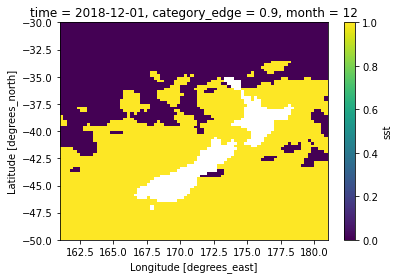

In [39]:
(obs_binary.sel(time="2018-12").squeeze() * mask_obs)["sst"].plot()

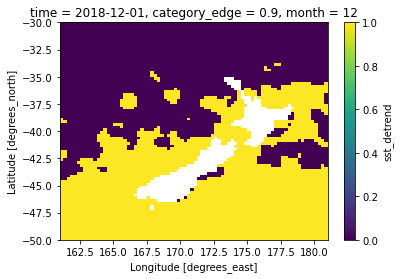

In [40]:
(obs_binary.sel(time="2018-12").squeeze() * mask_obs)[f"{varname}_detrend"].plot()

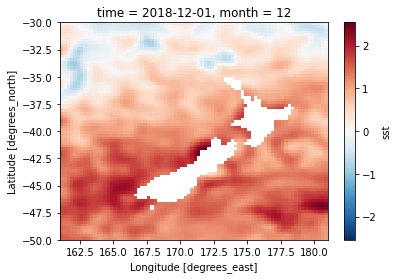

In [41]:
(dset_obs_anoms.sel(time="2018-12").squeeze() * mask_obs)["sst"].plot()

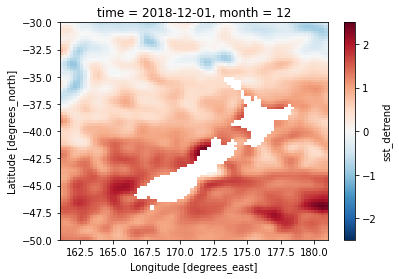

In [42]:
(dset_obs_anoms.sel(time="2018-12").squeeze() * mask_obs)[f"{varname}_detrend"].plot()

### Now reads the percentile climatology for the models 

In [43]:
percentile_climatology = xr.open_zarr(
    "../outputs/percentile_climatologies/percentile_90_climatologies_1993_2016.zarr/"
)

In [44]:
percentile_climatology

<xarray.Dataset>
Dimensions:        (GCM: 9, lat: 80, lon: 80, month: 12, step: 5)
Coordinates:
  * GCM            (GCM) object 'ECMWF' 'UKMO' ... 'ECCC_GEM5_NEMO'
    category_edge  float64 ...
  * lat            (lat) float32 -49.88 -49.62 -49.38 ... -30.62 -30.38 -30.12
  * lon            (lon) float32 161.1 161.4 161.6 161.9 ... 180.4 180.6 180.9
  * month          (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * step           (step) int64 1 2 3 4 5
Data variables:
    sst            (GCM, month, step, lat, lon) float64 dask.array<chunksize=(3, 6, 3, 40, 40), meta=np.ndarray>

In [45]:
import geopandas as gpd

In [46]:
NZ_coastline = gpd.read_file(
    "/home/nicolasf/data/shapefiles/NZ/NZpolygon/NZ_Polgon2.shp"
)

In [47]:
NZ_coastline = NZ_coastline.to_crs("EPSG:4326")

In [48]:
NZ_coastline_buffered = NZ_coastline.buffer(2)

/tmp/ipykernel_41820/291819866.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  NZ_coastline_buffered = NZ_coastline.buffer(2)


<AxesSubplot:>

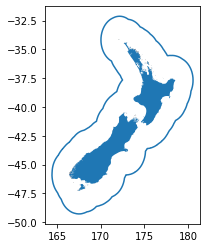

In [49]:
f, ax = plt.subplots()
NZ_coastline.plot(ax=ax)
NZ_coastline_buffered.boundary.plot(ax=ax)

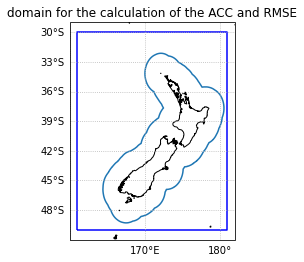

In [50]:
f, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)})

area.geometry.boundary.plot(ax=ax, transform=ccrs.PlateCarree(), color="b")

NZ_coastline_buffered.boundary.plot(ax=ax, transform=ccrs.PlateCarree())

ax.coastlines(resolution="10m")
ax.set_title("domain for the calculation of the ACC and RMSE")


gl = ax.gridlines(
    draw_labels=True,
    linestyle=":",
    xlocs=np.arange(-180, 180, 10),
    crs=ccrs.PlateCarree(),
)
gl.top_labels = False
gl.right_labels = False

### creates a mask 

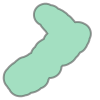

In [51]:
NZ_coastline_buffered.values[0]

In [52]:
NZ_coastline_buffered.to_frame(name="geometry")

,geometry
0,"POLYGON ((164.42599 -45.91816, 164.42598 -45.9..."


In [53]:
obs_binary = geo.make_mask_from_gpd(
    obs_binary,
    NZ_coastline_buffered.to_frame(name="geometry"),
    subset=False,
    domain_buffer=0.0,
)

In [54]:
obs_binary

<xarray.Dataset>
Dimensions:        (lat: 80, lon: 80, time: 499)
Coordinates:
  * lat            (lat) float32 -49.88 -49.62 -49.38 ... -30.62 -30.38 -30.12
  * lon            (lon) float32 161.1 161.4 161.6 161.9 ... 180.4 180.6 180.9
  * time           (time) datetime64[ns] 1982-01-01 1983-01-01 ... 2022-12-01
    category_edge  float64 0.9
    month          (time) int64 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12
Data variables:
    sst            (time, lat, lon) float32 dask.array<chunksize=(42, 10, 10), meta=np.ndarray>
    sst_detrend    (time, lat, lon) float32 dask.array<chunksize=(42, 10, 10), meta=np.ndarray>
    mask           (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

In [55]:
MHW_record = obs_binary.copy()

In [56]:
MHW_record = MHW_record[f"{varname}_detrend"] * MHW_record["mask"]

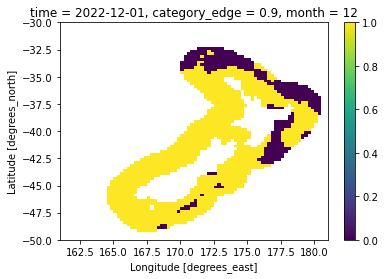

In [57]:
MHW_record.isel(time=-1).plot()

In [58]:
MHW_record = MHW_record.stack(z=("lat", "lon"))

In [59]:
MHW_record = MHW_record.dropna("z")

In [60]:
MHW_record = MHW_record.mean("z")

In [61]:
MHW_record_df = MHW_record.to_pandas()

In [62]:
MHW_record_df = MHW_record_df.loc["2017":,]

<AxesSubplot:xlabel='time'>

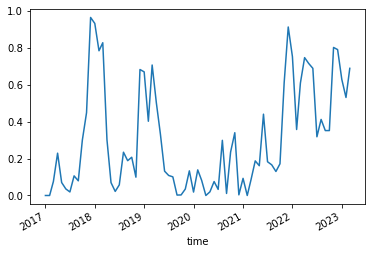

In [63]:
MHW_record_df.plot()

In [64]:
dset_obs_anoms = geo.make_mask_from_gpd(
    dset_obs_anoms,
    NZ_coastline_buffered.to_frame(name="geometry"),
    subset=False,
    domain_buffer=0.0,
)

In [65]:
coastal_anoms = dset_obs_anoms.copy()

In [66]:
coastal_anoms = coastal_anoms[[f"{varname}_detrend"]] * coastal_anoms["mask"]

In [67]:
coastal_anoms = coastal_anoms.stack(z=("lat", "lon"))

In [68]:
coastal_anoms = coastal_anoms.dropna("z")

In [69]:
coastal_anoms = coastal_anoms.mean("z")

In [70]:
coastal_anoms_df = coastal_anoms.to_pandas()

In [71]:
coastal_anoms_df = coastal_anoms_df.loc["2017":,]

<AxesSubplot:xlabel='time'>

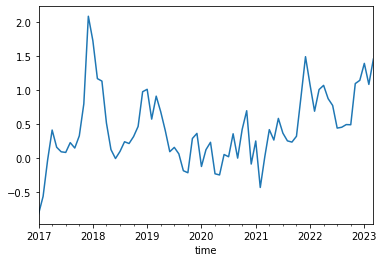

In [72]:
coastal_anoms_df[f"{varname}_detrend"].plot()

In [73]:
MHW_record_df = MHW_record_df.sort_index()

Text(0, 0.5, '% of grid points in MHW condition')

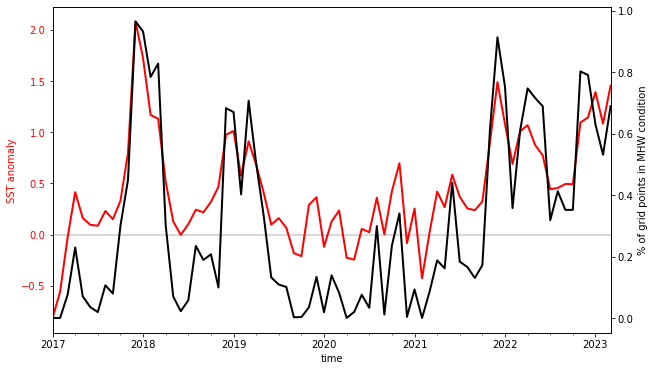

In [74]:
f, ax = plt.subplots(figsize=(10, 6))

coastal_anoms_df[f"{varname}_detrend"].plot(ax=ax, color="r", lw=2)

ax.tick_params(axis="y", labelcolor="r")

ax.set_ylabel("SST anomaly", color="r")

ax.axhline(0, color="0.8", zorder=-1)

ax2 = ax.twinx()

MHW_record_df.plot(ax=ax2, color="k", lw=2)

ax2.tick_params(axis="y", labelcolor="k")

ax2.set_ylabel("% of grid points in MHW condition")

In [75]:
MHW_id = MHW_record_df.mask(MHW_record_df < 0.5).dropna()

In [76]:
MHW_id

time
2017-12-01    0.965157
2018-01-01    0.932636
2018-02-01    0.784553
2018-03-01    0.828107
2018-12-01    0.682927
2019-01-01    0.670151
2019-03-01    0.707317
2019-04-01    0.502904
2021-11-01    0.612079
2021-12-01    0.913473
2022-01-01    0.752613
2022-03-01    0.609756
2022-04-01    0.747387
2022-05-01    0.716028
2022-06-01    0.689315
2022-11-01    0.802555
2022-12-01    0.790941
2023-01-01    0.629501
2023-02-01    0.531359
2023-03-01    0.689315
dtype: float64

In [77]:
MHW_id_start_and_stop = {}
MHW_id_start_and_stop['2017-2018'] = ['2017-12-01','2018-03-01']
MHW_id_start_and_stop['2018-2019'] = ['2018-12-01','2019-04-01']
MHW_id_start_and_stop['2021-2022'] = ['2021-11-01','2022-06-01']
MHW_id_start_and_stop['2022-2023'] = ['2022-11-01','2023-03-01']

In [83]:
df = coastal_anoms_df.loc[:,f'{varname}_detrend']

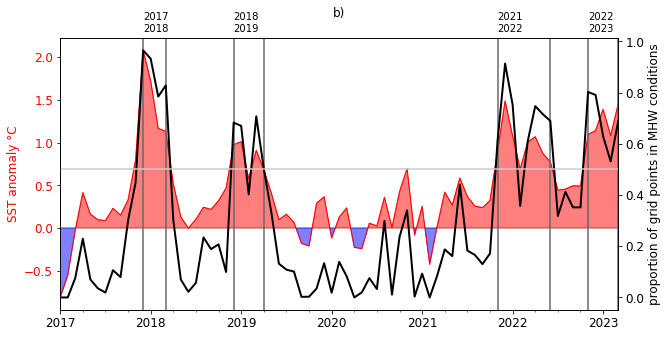

In [84]:
f, ax = plt.subplots(figsize=(10, 5))

coastal_anoms_df[f"{varname}_detrend"].plot(ax=ax, color="r", lw=1)

ax.fill_between(
    df.index, 0, df.values, df.values > 0, interpolate=True, color="r", alpha=0.5
)
ax.fill_between(
    df.index, 0, df.values, df.values <= 0, interpolate=True, color="b", alpha=0.5
)

ax.tick_params(axis="y", labelcolor="r")

ax.set_ylabel("SST anomaly \u00B0C", color="r", fontsize=12)

[l.set_fontsize(12) for l in ax.get_xticklabels()]
[l.set_fontsize(12) for l in ax.get_yticklabels()]

ax.axhline(0, color="0.8", zorder=-1)

ax2 = ax.twinx()

MHW_record_df.plot(ax=ax2, color="k", lw=2)

ax2.tick_params(axis="y", labelcolor="k")

ax2.set_ylabel("proportion of grid points in MHW conditions", fontsize=12)

ax2.axhline(0.5, color="0.8")

ax.set_title("b)\n")

ax.set_xlabel("")

[l.set_fontsize(12) for l in ax2.get_xticklabels()]
[l.set_fontsize(12) for l in ax2.get_yticklabels()]


for k in MHW_id_start_and_stop.keys(): 
    
    ax.axvline(x=MHW_id_start_and_stop[k][0], color='0.4')
    ax.axvline(x=MHW_id_start_and_stop[k][1], color='0.4')
    
    ax.text(MHW_id_start_and_stop[k][0], 2.3, "\n".join(k.split('-')), ha='left')

f.savefig('../figures/verification/SST/time-series_coastal_SST_MHW_conditions.png', **fig_kwargs)
f.savefig('../figures/verification/SST/time-series_coastal_SST_MHW_conditions.pdf', **fig_kwargs)

In [85]:
import cartopy.feature as cfeature

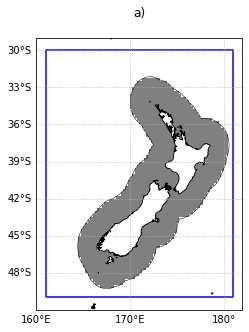

In [86]:
f, ax = plt.subplots(
    figsize=(5, 5), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180))
)

area.geometry.boundary.plot(ax=ax, transform=ccrs.PlateCarree(), color="b")

NZ_coastline_buffered.boundary.plot(
    ax=ax, transform=ccrs.PlateCarree(), color="k", lw=0.5
)

ax.coastlines(resolution="10m")

# ax.set_title("domain for the calculation of the ACC and RMSE")

obs_binary["mask"].plot(
    ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, cmap="gray"
)

gl = ax.gridlines(
    draw_labels=True,
    linestyle=":",
    xlocs=np.arange(-180, 180, 10),
    crs=ccrs.PlateCarree(),
)
gl.top_labels = False
gl.right_labels = False

ax.set_title("a)\n")

ax.set_extent(expand(domain, 1), crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, zorder=1, color="w")

f.savefig('../figures/verification/SST/mask_for_time-series_coastal_SST_MHW_conditions.png', **fig_kwargs)
f.savefig('../figures/verification/SST/mask_for_time-series_coastal_SST_MHW_conditions.pdf', **fig_kwargs)

### Now reads in the forecasts 

In [87]:
forecasts_path = "/media/nicolasf/END19101/ICU/data/CDS/operational/forecasts"

In [88]:
forecasts_path = pathlib.Path(forecasts_path)

In [89]:
GCM = "ECMWF"

In [90]:
gcm = C3S.get_one_GCM(
    dpath=forecasts_path,
    GCM=GCM,
    varname=varname,
    anomalies=False,
    ensemble_mean=False,
    domain=domain,
    detrend=False,
    start_year=2017,
    end_year=2022,
)

getting GCM data from /media/nicolasf/END19101/ICU/data/CDS/operational/forecasts/ECMWF/SST
reading 71 files

first: /media/nicolasf/END19101/ICU/data/CDS/operational/forecasts/ECMWF/SST/ensemble_seas_forecasts_sst_from_2017_01_ECMWF.netcdf
last: /media/nicolasf/END19101/ICU/data/CDS/operational/forecasts/ECMWF/SST/ensemble_seas_forecasts_sst_from_2022_12_ECMWF.netcdf


In [91]:
if GCM == "NCEP":
    print("Interpolating NCEP, calling `interp_NCEP`")

    gcm = utils.interp_NCEP(gcm, sst_hindcast_records="./SST_hindcast_summary.csv")

else:
    gcm[varname] = utils.interpolate_NaN_da(gcm[varname].load())

if period == "seasonal":
    gcm = gcm.rolling({"step": 3}, min_periods=3).mean("step")

    gcm = gcm.sel(step=slice(3, None))

gcm = gcm.transpose("time", "member", "step", "lat", "lon")

if not (obs_to_1deg):
    gcm = gcm.interp_like(dset_obs[["lon", "lat"]])

gcm = gcm.chunk({"member": -1, "time": -1, "step": -1, "lon": "auto", "lat": "auto"})

gcm = gcm * mask_obs

gcm = gcm.compute()

In [92]:
forecast_edges = percentile_climatology.sel(GCM=GCM)

In [93]:
# now derive binary forecasts, for each member of the GCM ensemble

forecasts_binary = []

for m in np.arange(12) + 1:
    forecastsm = gcm.sel(time=(gcm.time.dt.month == m))

    qm = forecast_edges.sel(month=m)

    b = forecastsm >= qm

    forecasts_binary.append(b * mask_obs)

forecasts_binary = xr.concat(forecasts_binary, dim="time")

forecasts_binary = forecasts_binary.sortby("time")

In [94]:
forecasts_binary

<xarray.Dataset>
Dimensions:        (time: 71, member: 51, step: 5, lon: 80, lat: 80)
Coordinates:
  * time           (time) datetime64[ns] 2017-01-01 2017-02-01 ... 2022-12-01
  * member         (member) int32 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50
  * step           (step) int64 1 2 3 4 5
  * lon            (lon) float32 161.1 161.4 161.6 161.9 ... 180.4 180.6 180.9
  * lat            (lat) float32 -49.88 -49.62 -49.38 ... -30.62 -30.38 -30.12
    GCM            <U5 'ECMWF'
    category_edge  float64 ...
    month          (time) int64 1 2 3 4 5 6 7 8 9 11 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst            (time, member, step, lat, lon) float32 dask.array<chunksize=(1, 51, 3, 10, 10), meta=np.ndarray>

In [97]:
MHW_id_start_and_stop

{'2017-2018': ['2017-12-01', '2018-03-01'],
 '2018-2019': ['2018-12-01', '2019-04-01'],
 '2021-2022': ['2021-11-01', '2022-06-01'],
 '2022-2023': ['2022-11-01', '2023-03-01']}

In [98]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [131]:
date_start = datetime.strptime(MHW_id_start_and_stop['2018-2019'][0], '%Y-%m-%d') 

In [132]:
date_stop = date_start + relativedelta(months=5)

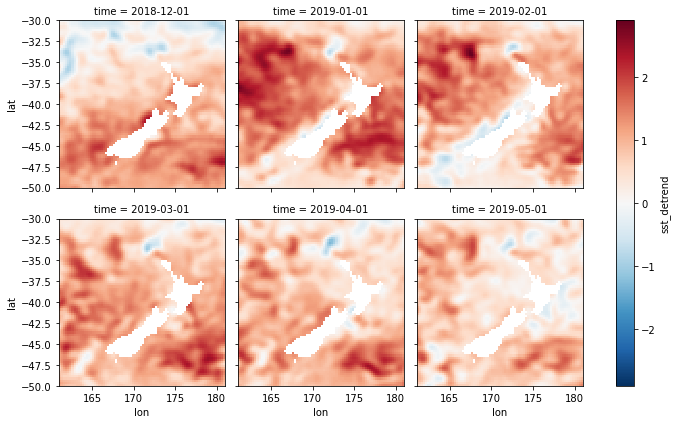

In [133]:
dset_obs_anoms.sel(time=slice(date_start, date_stop))['sst_detrend'].plot(col='time', col_wrap=3)

In [134]:
obs_binary = obs_binary.load()

In [135]:
obs_binary = obs_binary.sortby('time')

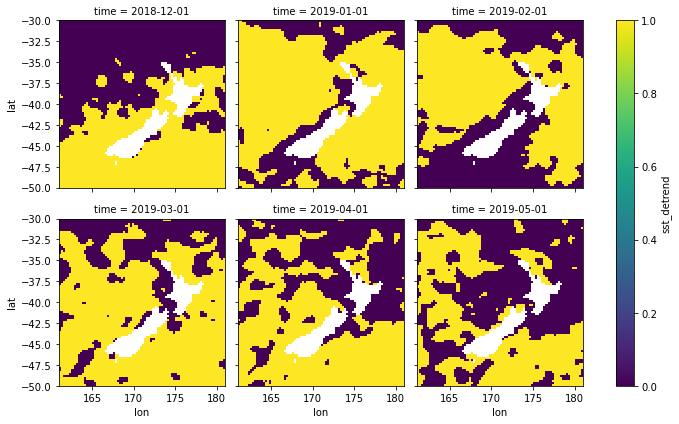

In [136]:
obs_binary.sel(time=slice(date_start, date_stop))['sst_detrend'].plot(col='time', col_wrap=3)

In [148]:
forecasts_binary_aligned = forecasts_binary.shift({'time':-1})

In [149]:
forecasts_binary_aligned = forecasts_binary_aligned.mean('member')

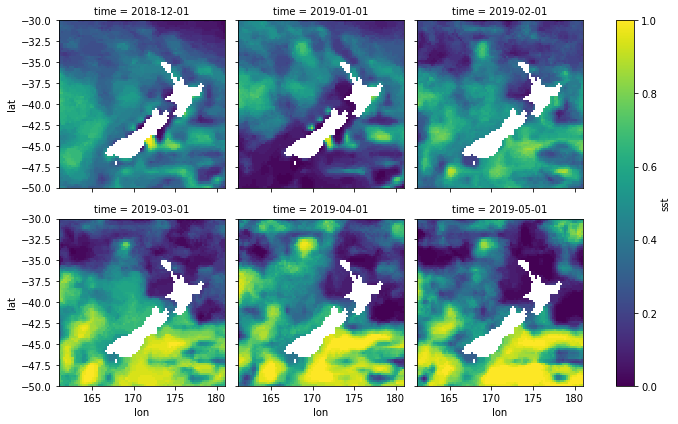

In [150]:
forecasts_binary_aligned.sel(step=1, time=slice(date_start, date_stop))['sst'].plot(col='time', col_wrap=3)

In [151]:
obs_binary['mask']

<xarray.DataArray 'mask' (lat: 80, lon: 80)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat            (lat) float32 -49.88 -49.62 -49.38 ... -30.62 -30.38 -30.12
  * lon            (lon) float32 161.1 161.4 161.6 161.9 ... 180.4 180.6 180.9
    category_edge  float64 0.9

In [153]:
forecasts_binary['mask'] = obs_binary['mask']

In [154]:
forecasts_binary

<xarray.Dataset>
Dimensions:        (time: 71, member: 51, step: 5, lon: 80, lat: 80)
Coordinates:
  * time           (time) datetime64[ns] 2017-01-01 2017-02-01 ... 2022-12-01
  * member         (member) int32 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50
  * step           (step) int64 1 2 3 4 5
  * lon            (lon) float32 161.1 161.4 161.6 161.9 ... 180.4 180.6 180.9
  * lat            (lat) float32 -49.88 -49.62 -49.38 ... -30.62 -30.38 -30.12
    GCM            <U5 'ECMWF'
    category_edge  float64 ...
    month          (time) int64 1 2 3 4 5 6 7 8 9 11 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst            (time, member, step, lat, lon) float32 dask.array<chunksize=(1, 51, 3, 10, 10), meta=np.ndarray>
    mask           (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan